In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from conditionalconformal.synthetic_data import generate_cqr_data, indicator_matrix
from conditionalconformal import CondConf

In [3]:
# generate data
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=1, n_calib=2000)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# nominal level is 0.9
alpha = 0.1

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn_groups(x):
    return indicator_matrix(x, disc)

# coverage on Gaussians with mu=loc and sd=scale 
# scale = 1 for x != [1.5, 3.5]
eval_locs = [1.5, 3.5]
eval_scale = 0.2

other_locs = [0.5, 2.5, 4.5]
other_scale = 1

def phi_fn_shifts(x):
    shifts = [norm.pdf(x, loc=loc, scale=eval_scale).reshape(-1,1)
                   for loc in eval_locs]
    shifts.extend([norm.pdf(x, loc=loc, scale=other_scale).reshape(-1,1)
                   for loc in other_locs])
    shifts.append(np.ones((x.shape[0], 1)))
    return np.concatenate(shifts, axis=1)

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

In [30]:
experiment = 'groups' # valid choices: ['groups', 'shifts', 'agnostic']

In [32]:
if experiment == 'groups':
    phi_fn = phi_fn_groups
    infinite_params = {}
elif experiment == 'shifts':
    phi_fn = phi_fn_shifts
    infinite_params = {}
elif experiment == 'agnostic':
    phi_fn = phi_fn_intercept
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}
else:
    raise ValueError(f"Invalid value for experiment: {experiment}.")

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)

n_test = len(x_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

lbs_r = np.zeros((n_test,))
ubs_r = np.zeros((n_test,))

i = 0
for x_t in tqdm(x_test):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=True, randomize=True)
    lbs[i] = res[0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=True, randomize=True)
    ubs[i] = res[1]
    
#     res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=True, randomize=False)
#     lbs[i] = res[0]
#     res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=True, randomize=False)
#     ubs[i] = res[1]
    i += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 443.40it/s]


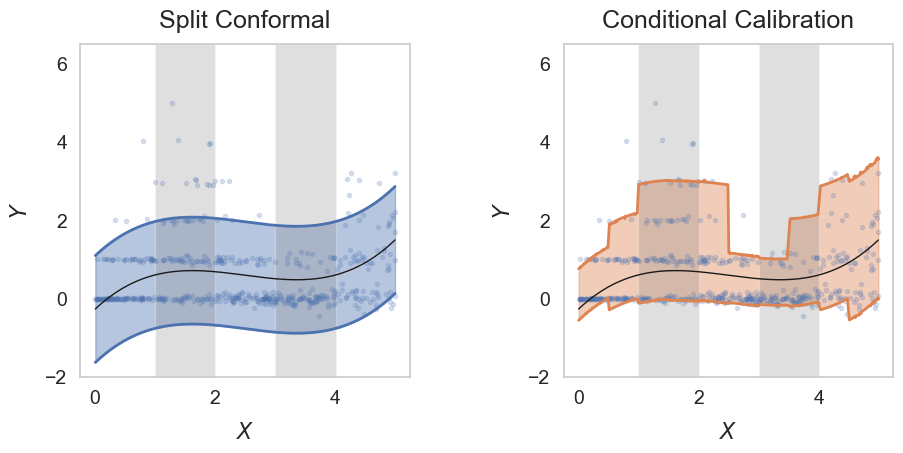

In [33]:
# plot predictions

q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(10.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]
lb_r = lbs_r[sort_order]
ub_r = ubs_r[sort_order]


ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

if experiment == 'groups':
    ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 2, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')

# ax2.plot(x_test_s, ub_r, color=cp[2], lw=2)
# ax2.plot(x_test_s, lb_r, color=cp[2], lw=2)
# ax2.fill_between(x_test_s.flatten(), lb_r, 
#                  ub_r, 
#                  color=cp[2], alpha=0.4, label='conditional calibration (randomized)')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

if experiment == 'groups':
    ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax2.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

plt.tight_layout(pad=5)

In [66]:
def obtain_estimates(seed, x_train_2, y_train_2):
    _, _, x_calib_2, y_calib_2, x_test_2, y_test_2 = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_2), y_train_2)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))

    def phi_fn(x):
        return np.ones((x.shape[0], 1))
    alpha = 0.1
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}


    gcc_ub = CondConf(score_fn, phi_fn, infinite_params)
    gcc_ub.setup_problem(1 - alpha/2, x_calib_2, y_calib_2)

    gcc_lb = CondConf(score_fn, phi_fn, infinite_params)
    gcc_lb.setup_problem(alpha/2, x_calib_2, y_calib_2)

    w_1 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 1.5))[0]
    w_1[ind] = 1

    w_2 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 3.5))[0]
    w_2[ind] = 1
    miscover_ub_1 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_1)[0]
    miscover_ub_2 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_2)[0]

    miscover_lb_1 = gcc_lb.estimate_coverage(alpha/2, w_1)[0]
    miscover_lb_2 = gcc_lb.estimate_coverage(alpha/2, w_2)[0]
    return miscover_ub_1 + miscover_lb_1, miscover_ub_2 + miscover_lb_2

def estimate_coverage(seed, shift_fns = []):
    _, _, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=seed, n_calib=2000)
    cond_conf = CondConf(score_fn, phi_fn, infinite_params)
    cond_conf.setup_problem(x_calib, y_calib)
    upper_cover = cond_conf.verify_coverage(x_test, y_test, 1 - alpha/2, randomize=True)
    cond_conf = CondConf(score_fn, phi_fn, infinite_params)
    cond_conf.setup_problem(x_calib, y_calib)
    lower_cover = cond_conf.verify_coverage(x_test, y_test, alpha/2, randomize=True)
    cover = ~(upper_cover & lower_cover)
    
    q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                    np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)
    cover_split = ~(np.abs(reg.predict(poly.fit_transform(x_test)) - y_test) < q)
    shift_covers = []
    marginal_cover = np.asarray((cover_split.mean(), cover.mean()))
    for shift_fn in shift_fns:
        shift_cover = np.zeros((2,))
        shift_cover[0] = (shift_fn(x_test).flatten() * cover_split).sum() / shift_fn(x_test).sum()
        shift_cover[1] = (shift_fn(x_test).flatten() * cover.flatten()).sum() / shift_fn(x_test).sum()
        shift_covers.append(shift_cover)
    return marginal_cover, *shift_covers

import pickle

if experiment == 'groups':
    with open('data/groups_results.pkl', 'rb') as fp:
        results = pickle.load(fp)
elif experiment == 'shifts':
    with open('data/shifts_results.pkl', 'rb') as fp:
        results = pickle.load(fp)
elif experiment == 'agnostic':
    with open('data/agnostic_results_4.pkl', 'rb') as fp:
        results = pickle.load(fp)
    estimates_1 = []
    estimates_2 = []
    x_train, y_train, _, _, _, _ = generate_cqr_data(seed=1)
    for seed in tqdm(range(200)):
        est_1, est_2 = obtain_estimates(seed + 1000, x_train, y_train)
        estimates_1.append(est_1)
        estimates_2.append(est_2)


In [67]:
shift_fn_1 = lambda x : np.logical_and(x > 1, x < 2)
shift_fn_2 = lambda x : np.logical_and(x > 3, x < 4)

# shift_fn_1 = lambda x: norm.pdf(x, loc=1.5, scale=0.2).reshape(-1,1)
# shift_fn_2 = lambda x: norm.pdf(x, loc=3.5, scale=0.2).reshape(-1,1)
n_trials = 500
marginal_cov = np.zeros((n_trials,2))
cov_1 = np.zeros((n_trials,2))
cov_2 = np.zeros((n_trials,2))
for seed in tqdm(range(n_trials)):
    marginal_cov[seed], cov_1[seed], cov_2[seed] = estimate_coverage(seed, [shift_fn_1, shift_fn_2])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:58<00:00,  1.20s/it]


In [68]:
if experiment == 'agnostic':
    method_1 = 'Estimated'
    method_2 = 'Empirical'
else:
    method_1 = 'Split'
    method_2 = 'Conditional'

# marginal_cov = results[0]
coverageData = pd.DataFrame({'Method': [method_1] * len(marginal_cov), 
                             'Range' : ['Marginal'] * len(marginal_cov), 
                             'Miscoverage': np.asarray(marginal_cov)[:,0]})

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(marginal_cov), 
                               'Range' : ['Marginal'] * len(marginal_cov), 
                               'Miscoverage': np.asarray(marginal_cov)[:,1]
                              }
                          )],
                         axis=0)
                          
# cov_1 = results[1]
if experiment == 'groups':
    cov1_name = '[1,2]'
elif experiment == 'shifts':
    cov1_name = '$f_1$'
elif experiment == 'agnostic':
    cov1_name = '$f_1$'
    cov_1 = np.asarray(cov_1)
    cov_1[:,0] = np.asarray(estimates_1)
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_1] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,0]
                              }
                          )], 
                         axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,1]
                              }
                          )], axis=0)
                          
# cov_2 = results[2]
if experiment == 'groups':
    cov2_name = '[3,4]'
elif experiment == 'shifts':
    cov2_name = '$f_2$'
elif experiment == 'agnostic':
    cov2_name = '$f_2$'
    cov_2 = np.asarray(cov_2)
    cov_2[:,0] = np.asarray(estimates_2)
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_1] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,0]
                              }
                          )], axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,1]
                              }
                          )], axis=0)

if experiment == 'agnostic':
    coverageData = coverageData[coverageData['Range'] != "Marginal"]

In [72]:
q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]


ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

if experiment == 'groups':
    ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

if experiment == 'groups':
    ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax2.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)
    
ax3 = fig.add_subplot(1, 3, 3)
f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
f.axhline(0.1, color='red')
f.legend_.remove()
ax3.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
if experiment == 'groups':
    ax3.set_xlabel("Groups", fontsize=18, labelpad=10)
else:
    ax3.set_xlabel("Shifts", fontsize=18, labelpad=10)
ax3.set_ylim(0.,0.2)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)
plt.savefig(f'figures/cqrDataComparison_{experiment}.pdf')

<Figure size 1750x600 with 3 Axes>


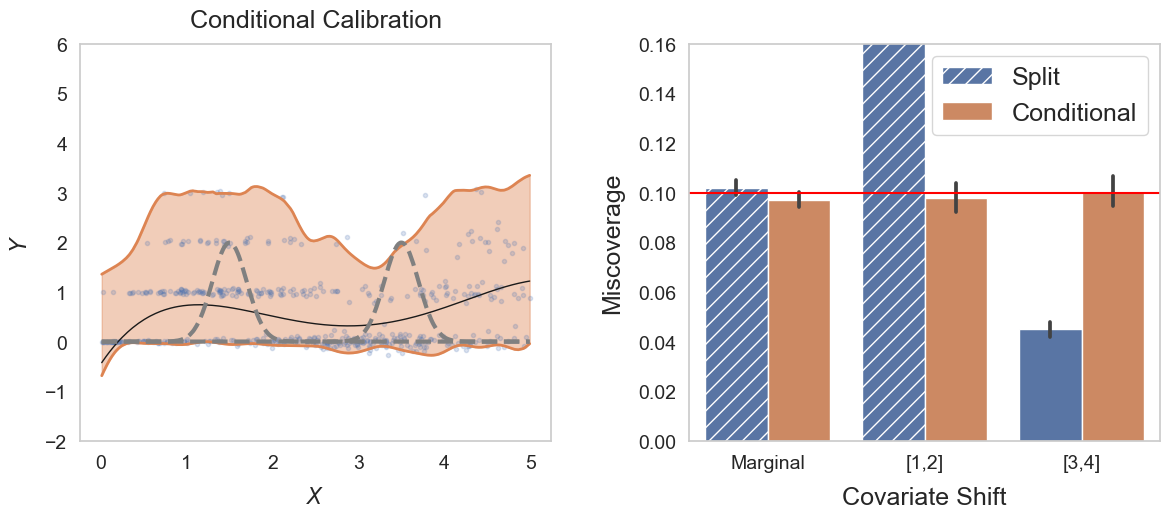

In [121]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(12.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb_ag = lbs[sort_order]
ub_ag = ubs[sort_order]

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, ub_ag, color=cp[1], lw=2)
ax1.plot(x_test_s, lb_ag, color=cp[1], lw=2)
ax1.fill_between(x_test_s.flatten(), lb_ag, ub_ag, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax1.set_ylim(-2,6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Conditional Calibration", fontsize=18, pad=12)

for loc in eval_locs:
    ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 2, 2)

f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax2
)
orange = f.patches[2].get_facecolor()
f.patches[0].set_hatch('//')
f.patches[0].set_facecolor(orange)
f.patches[1].set_hatch('//')
f.patches[1].set_facecolor(orange)

plt.draw()
f.axhline(0.1, color='red')
f.legend_.remove()
# plt.legend(fontsize=18)
ax2.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
ax2.set_xlabel("Covariate Shift", fontsize=18, labelpad=10)
ax2.set_ylim(0.,0.16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend(fontsize=18)
plt.tight_layout(pad=3)

# plt.savefig(f'figures/cqrDataComparison_{experiment}.pdf')